In [2]:
import pandas as pd
from tqdm import tqdm
from tsfresh.utilities.dataframe_functions import impute

def preprocess(data_path, samples):

    data = pd.read_parquet(data_path)[:samples]
    data = data.sort_values('id').reset_index(drop = True)
    if 'train' in data_path:
        y = data.set_index('id')['label']
        X_dict = {'id': [], 'dates' : [], 'values': [], 'label': []}
    else: 
        X_dict = {'id': [], 'dates' : [], 'values': []}

    for i in tqdm(range(len(data))):
        for j in range(len(data.iloc[i]['dates'])):
            X_dict['id'].append(data.iloc[i]['id'])
            X_dict['dates'].append(data.iloc[i]['dates'][j])
            X_dict['values'].append(data.iloc[i]['values'][j])
            try:
                X_dict['label'].append(data.iloc[i]['label'])
            except Exception:
                continue

    X = pd.DataFrame(X_dict)

    if 'train' in data_path:
        X.to_parquet('train_preprocessed.parquet')
        return X, y

    else:
        X.to_parquet('test_preprocessed.parquet')
        return X

#### Из-за ограничений в вычислительных мощностях берём только 2000 сэмплов

In [4]:
X_train, y_train = preprocess('./train.parquet', 2000)
X_test = preprocess('./test.parquet', 20000)

100%|██████████| 2000/2000 [00:16<00:00, 117.82it/s]


In [5]:
X_train = pd.read_parquet('./train_preprocessed.parquet')
X_test = pd.read_parquet('./test_preprocessed.parquet')

#### Также мы имеем пропуски в данных, о пририроде которых мы не знаем ничего, поэтому заполним их распространением вперед

In [6]:
print(X_train.isnull().sum())
print(X_test.isnull().sum())

id         0
dates      0
values    93
label      0
dtype: int64
id           0
dates        0
values    1079
dtype: int64


In [7]:
X_train.fillna(method='ffill', inplace=True)
X_test.fillna(method='ffill', inplace=True)

#### Делим выборку на тренировочную и валидационную

In [8]:
X_train, X_valid, y_tr, y_val = X_train[['id','dates', 'values']][:70000], X_train[['id','dates', 'values']][70000:], X_train['label'][:70000], X_train['label'][70000:]

In [9]:
from tsfresh import extract_features

X_train_features = extract_features(X_train, column_id='id', column_sort='dates', impute_function=impute)
X_valid_features = extract_features(X_valid, column_id='id', column_sort='dates', impute_function=impute)

Feature Extraction: 100%|██████████| 40/40 [00:07<00:00,  5.65it/s]


In [10]:
y_tr = y_train[:len(X_train_features)]
y_val = y_train[len(X_train_features): len(X_train_features) + len(X_valid_features)]

#### Отбираем фичи на трейне и проверяем на валидации, чтобы не было лика данных

In [11]:
from tsfresh import select_features

X_train_filtered = select_features(X_train_features, y_tr)
X_valid_filtered = X_valid_features[X_train_filtered.columns][1:]

In [12]:
from xgboost import XGBClassifier

clf = XGBClassifier()
clf.fit(X_train_filtered, y_tr)
pred = clf.predict_proba(X_valid_filtered)

In [13]:
from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score, roc_curve
import matplotlib.pyplot as plt

def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

def get_metrics(target : list, pred: list):
    print(f'roc-auc score: {roc_auc_score(target, pred)}')
    print(f'recall: {recall_score(target, pred)}')
    print(f'precision: {precision_score(target, pred)}')
    print(f'f1: {f1_score(target, pred)}')

0.8656295057734482
Threshold value is: 0.23686714


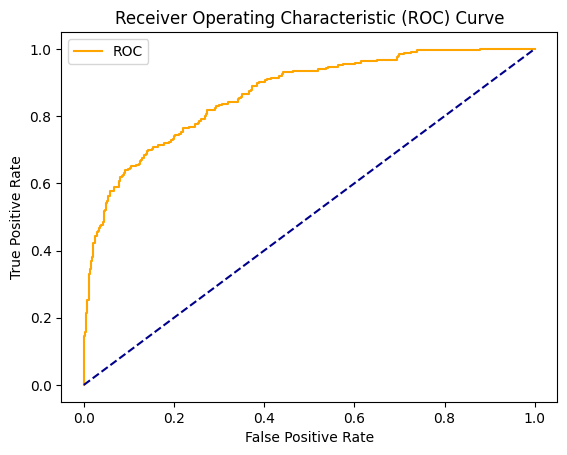

roc-auc score: 0.7780584735802649
recall: 0.6991869918699187
precision: 0.6417910447761194
f1: 0.6692607003891051


In [14]:
import numpy as np

fpr, tpr, thresholds = roc_curve(y_val[:], pred[:,1])
print(roc_auc_score(y_val[:], pred[:,1]))
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
plot_roc_curve(fpr, tpr)
get_metrics(y_val[:], pred[:,1]>=optimal_threshold)

In [15]:
X_test_features = extract_features(X_test, column_id='id', column_sort='dates', impute_function=impute)
X_test_filtered = X_test_features[X_train_filtered.columns]
X_test_filtered.to_parquet('X_test_filtered.parquet')

Feature Extraction: 100%|██████████| 40/40 [02:27<00:00,  3.69s/it]


In [16]:
clf.save_model('clf.json')